In [2]:
# The following script is not that great.
# I just got out of GPU in Colab, and the file is so big, that it crashes the runtime all the time.
# So this script is just a simple implementation
# As the process is consuming all the possible memory, my script is written without TF/Keras.
# I had some issues with Windows, CUDA and CuDNN, otherwise I would be able to write a full code

In [19]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [20]:
# Step 1: Preprocessing
corpus_file = "corpus_100k"
words = []

# Extract the text from the corpus file
file = open(corpus_file, "r", encoding="utf-8")
corpus = file.read()
file.close()
# Lowercase is just for the vocab size reduce
corpus = corpus.lower()

In [21]:
# Removing all the symbols, which are not required for the vocabulary
remove = ".։՝,«»՞"

for symbol in remove:
    corpus = corpus.replace(symbol, "")

corpus = corpus.replace(" - ", "")

In [27]:
# I just took a little part of the entire text, so it would be able to 
words = corpus.split()[:5000]
vocab = set(words)

In [28]:
len(words), len(vocab)

(5000, 2093)

In [29]:
# This approach uses the neg sampling loss
# So we are not saving a 2093x2093 matrix
WINDOW_SIZE = 3
NUM_NEGATIVE_SAMPLES = 3

data = []

#iterate over all words
for idx, center_word in enumerate(words[WINDOW_SIZE-1:-WINDOW_SIZE]):

    #iterate over the context words around the center word
    context_words = [context_word for context_word in words[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word]
    for context_word in context_words:

        #get words NOT in the current context as negative examples
        data.append([center_word, context_word, 1])
        negative_samples = np.random.choice([w for w in words[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], NUM_NEGATIVE_SAMPLES)

        for negative_samp in negative_samples:

            #add a training row
            data.append([center_word, negative_samp, 0])

In [10]:
data[:15]

[['կարող', 'հիմա', 1],
 ['կարող', 'փող', 0],
 ['կարող', 'ժամանակ', 0],
 ['կարող', 'անի', 0],
 ['կարող', 'ես', 1],
 ['կարող', 'նայեք', 0],
 ['կարող', 'համար', 0],
 ['կարող', 'դաշտ', 0],
 ['կարող', 'է', 1],
 ['կարող', 'հոգնեցրած', 0],
 ['կարող', 'հանցագործություն', 0],
 ['կարող', 'կան', 0],
 ['կարող', 'մի', 1],
 ['կարող', 'եւ', 0],
 ['կարող', 'այն', 0]]

In [30]:
# Conver the list to dataframe for easier usage in NumPy
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)

In [31]:
df

,center_word,context_word,label
0,կարող,հիմա,1
1,կարող,են,0
2,կարող,մենք,0
3,կարող,+,0
4,կարող,ես,1
...,...,...,...
79579,տեղական,անհատ,0
79580,տեղական,միջպետական,1
79581,տեղական,որ,0
79582,տեղական,հանրությունկառավարություն,0


In [32]:
# With neg sampling sigmoid is the preferable activation
def sigmoid(v, scale=1):
    return 1 / (1 + np.exp(-scale*v))

In [33]:
# simple implementation of gradient descent
# there is not even a fully implemented bacckprop
# we are doing it like a regular regression
def update_embeddings(df, main_embeddings, context_embeddings, learning_rate, debug=False):

    #get differences between main embeddings and corresponding context embeddings
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    diffs = context_embeddings_context - main_embeddings_center

    #get similarities, scores, and errors between main embeddings and corresponding context embeddings
    dot_prods = np.sum(main_embeddings_center * context_embeddings_context, axis=1)
    scores = sigmoid(dot_prods)
    errors = (df.label - scores).values.reshape(-1,1)

    #calculate updates
    updates = diffs*errors*learning_rate
    updates_df = pd.DataFrame(data=updates)
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()

    if debug:
        plot_words(debug)

    #apply updates
    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]

    #normalize embeddings
    main_embeddings = normalize_data(main_embeddings)
    context_embeddings = normalize_data(context_embeddings)

    #return the updated embeddings
    return main_embeddings, context_embeddings

In [ ]:
# Auxilary functions

In [34]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

In [35]:
# If the training goes well, in the plots of left column vectors will try to reach 0 degree angle
# In the right column the vectors will try to reach the 90 degree angle
def plot_words(debug):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)

    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

    ###################################

    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)

    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

    plt.show()

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


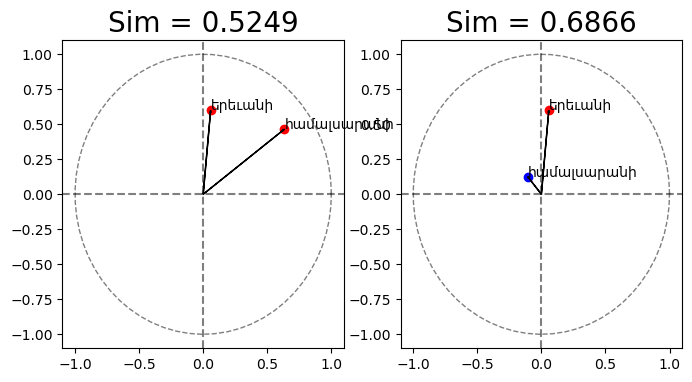

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


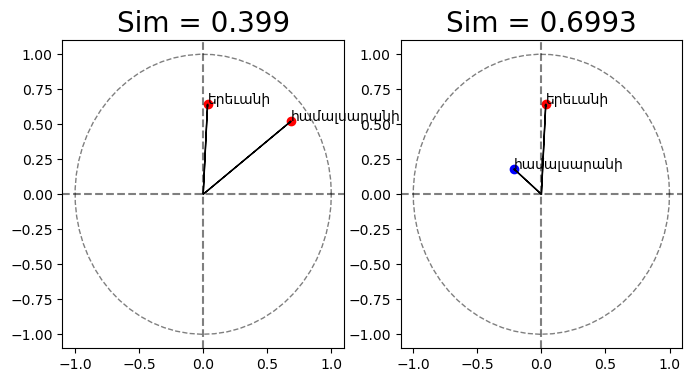

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


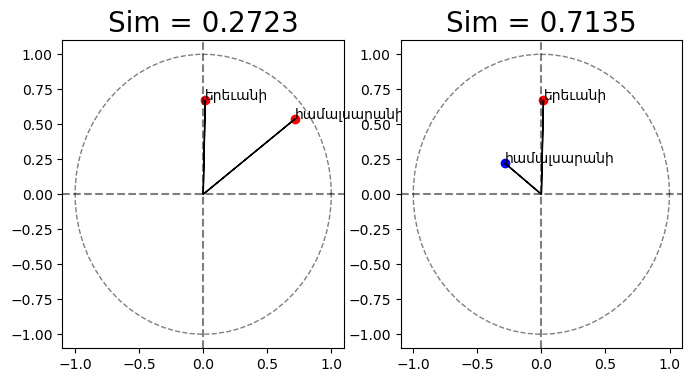

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


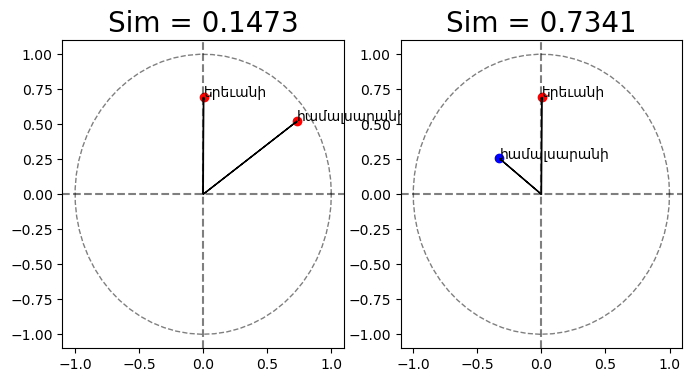

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


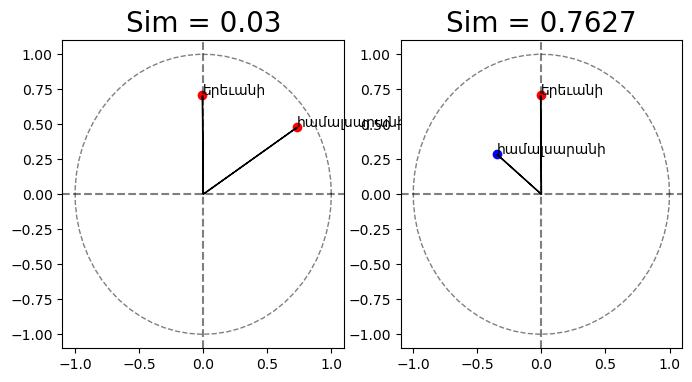

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


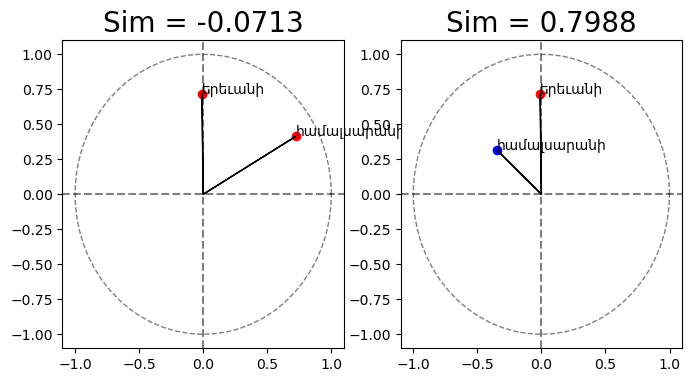

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


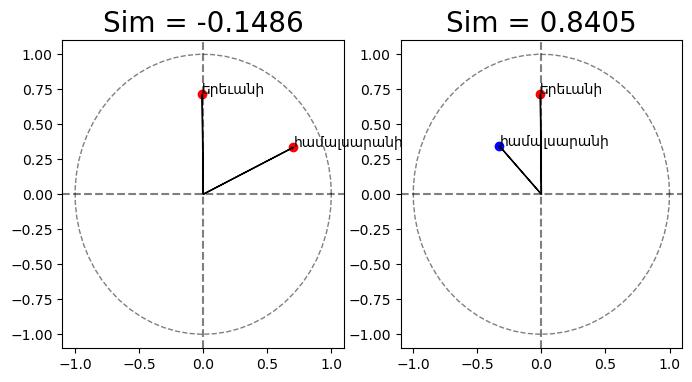

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


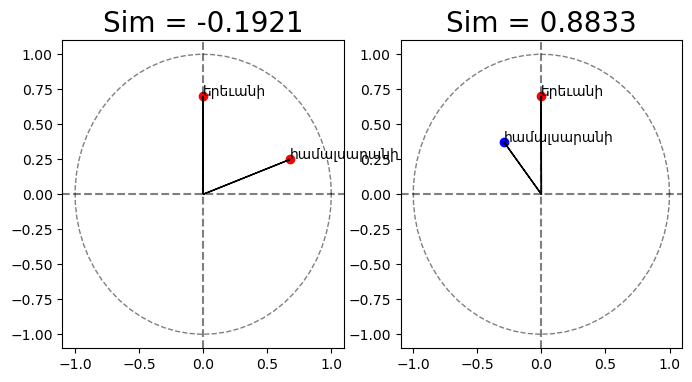

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


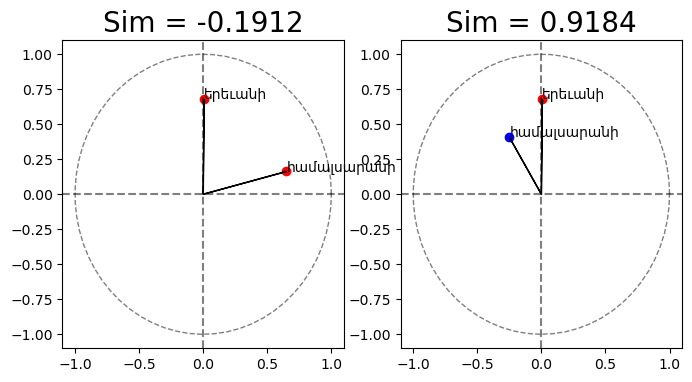

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


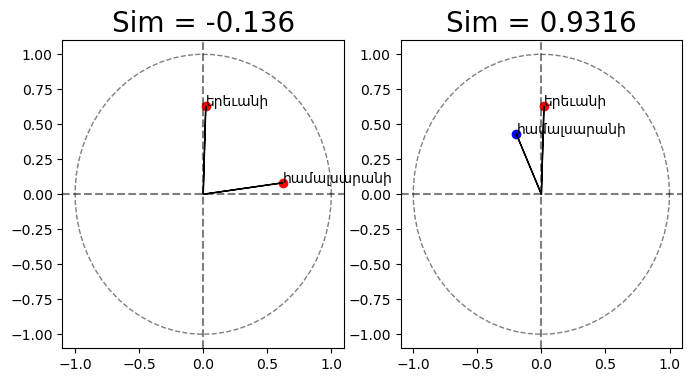

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


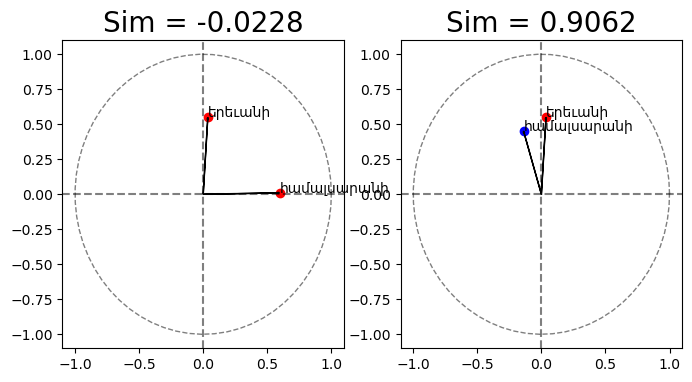

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


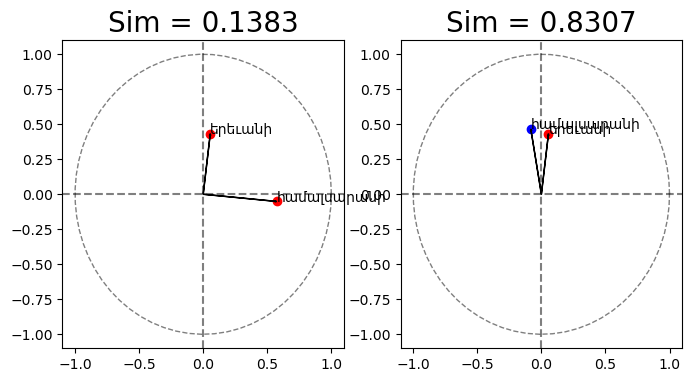

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


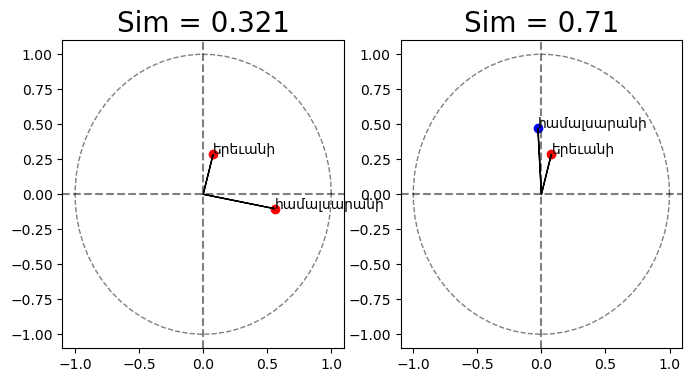

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


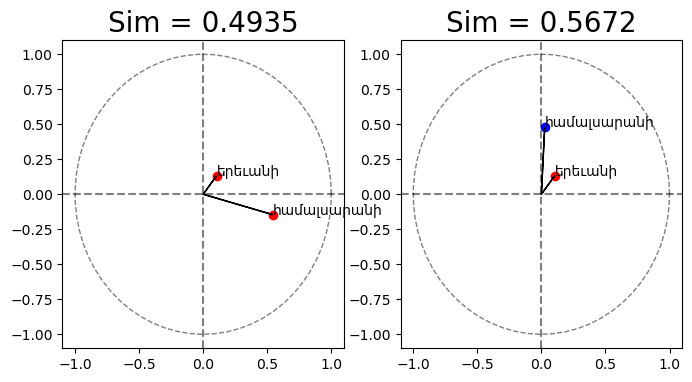

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


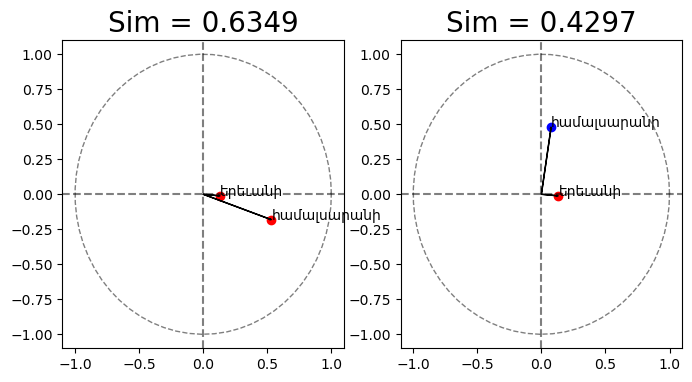

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


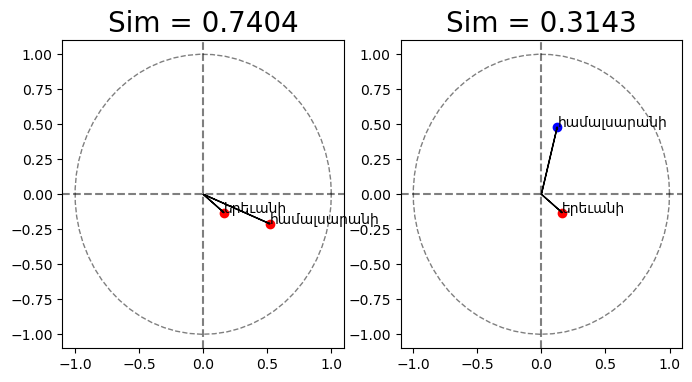

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


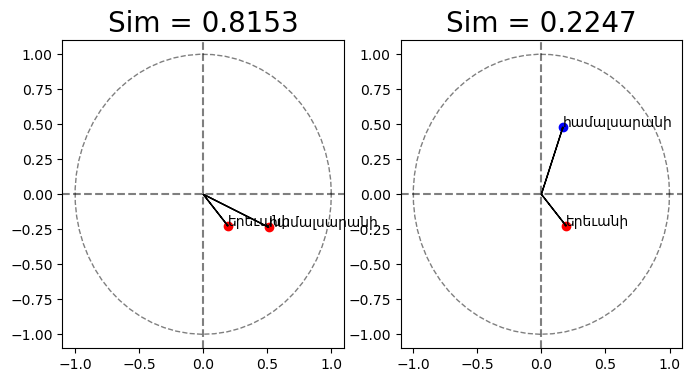

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


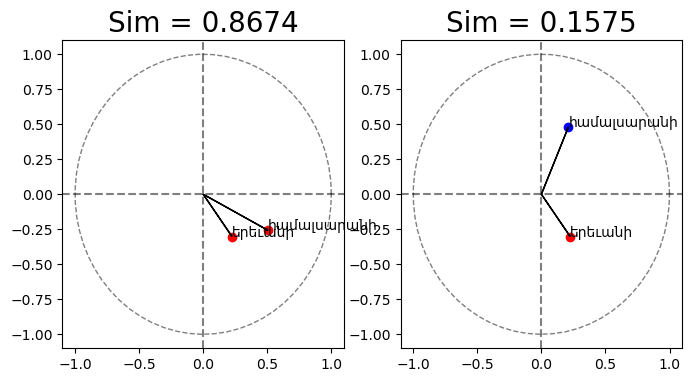

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


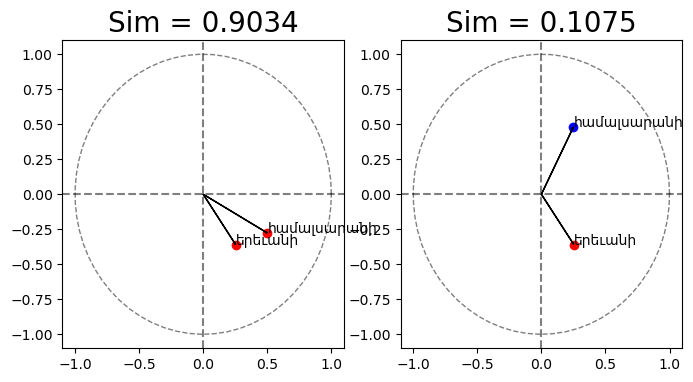

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


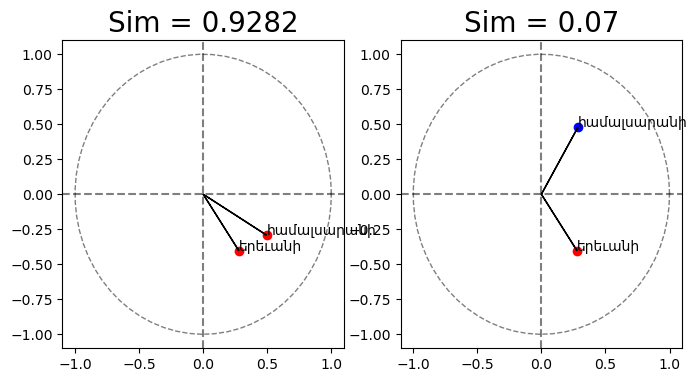

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


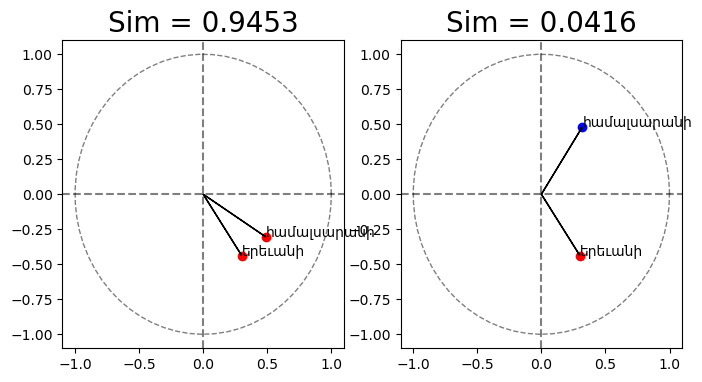

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


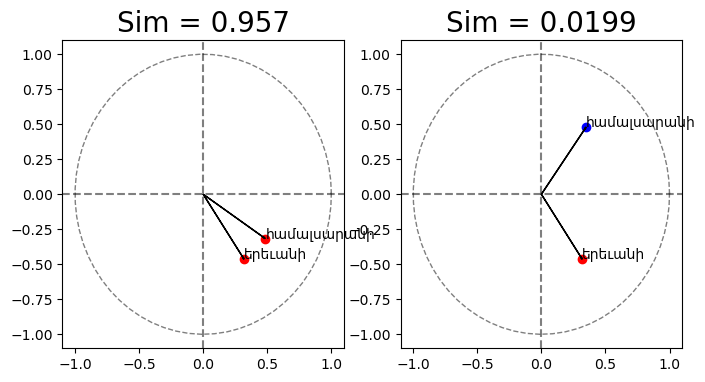

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


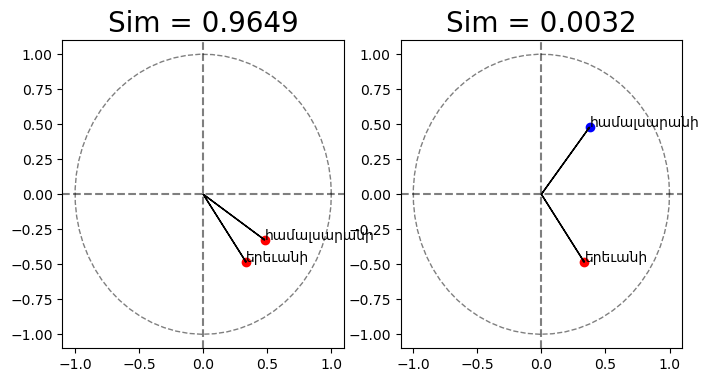

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


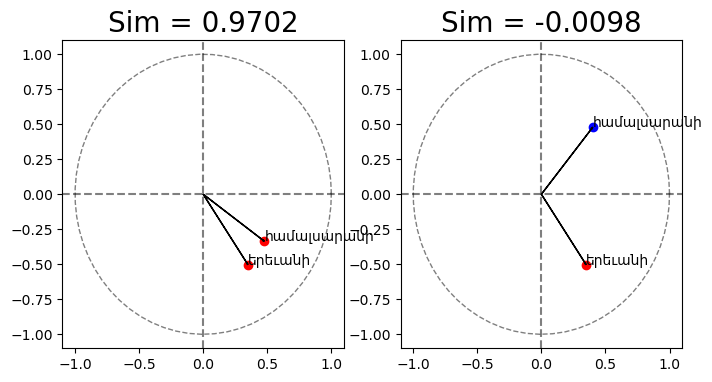

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


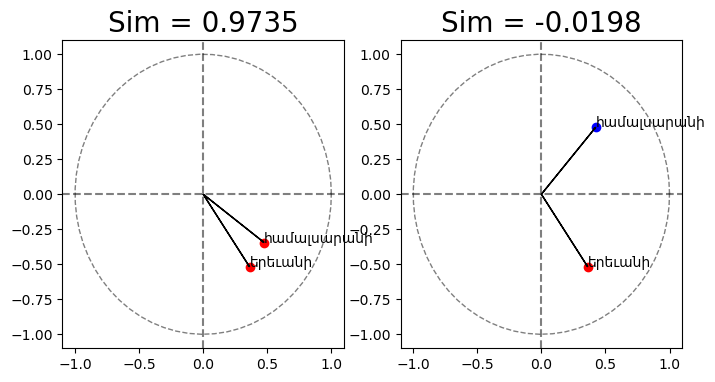

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


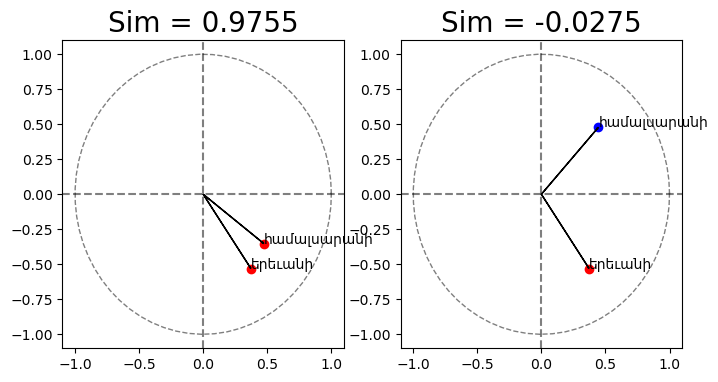

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


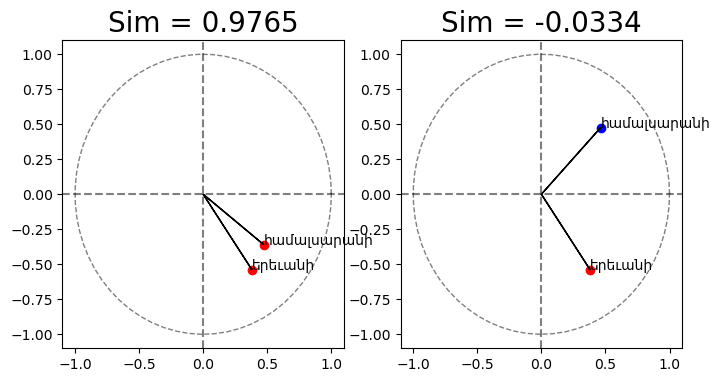

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


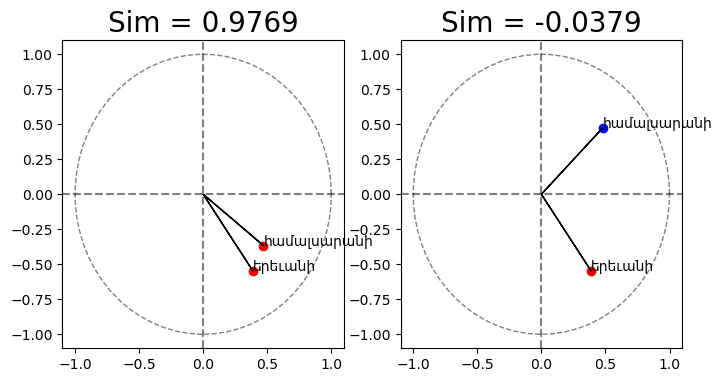

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


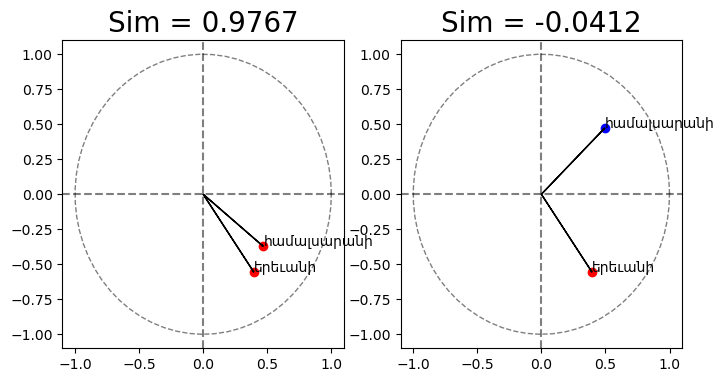

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


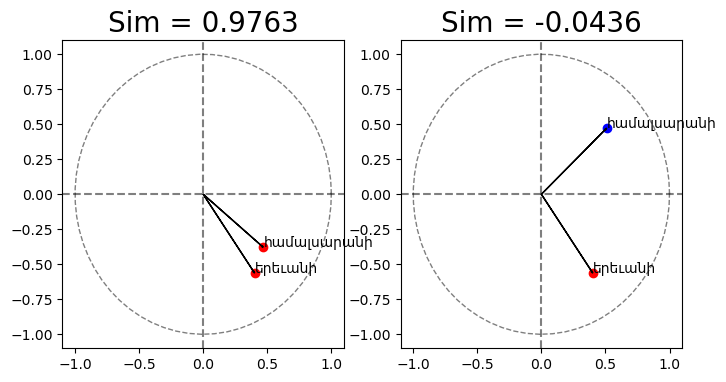

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


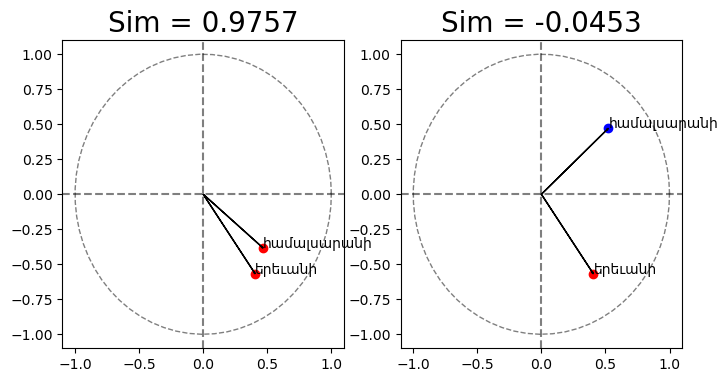

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


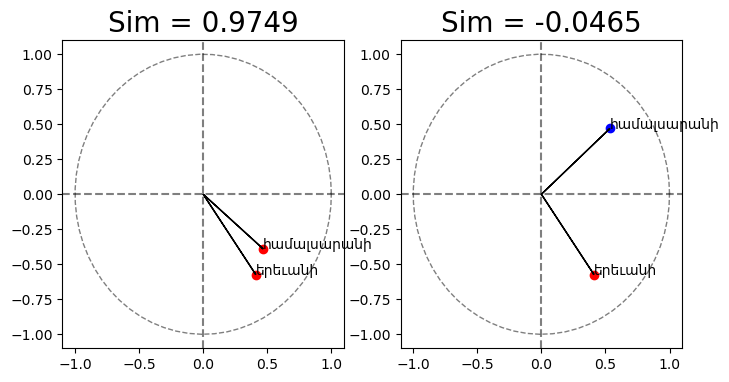

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


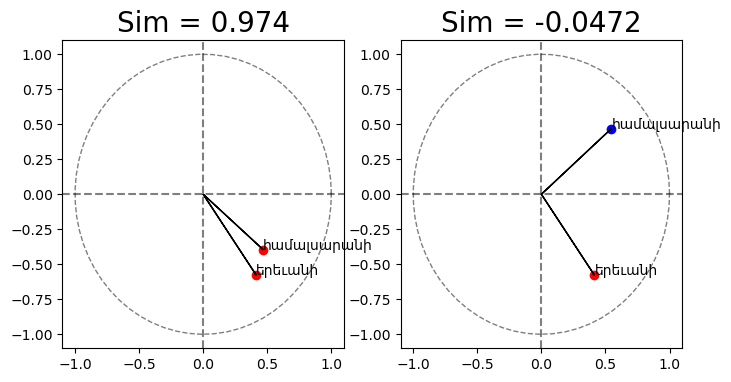

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


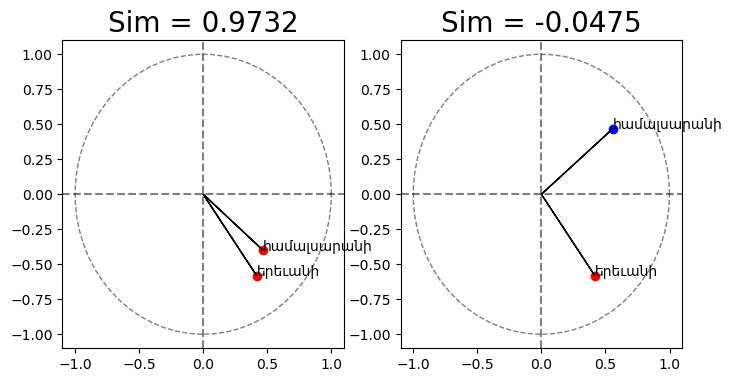

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


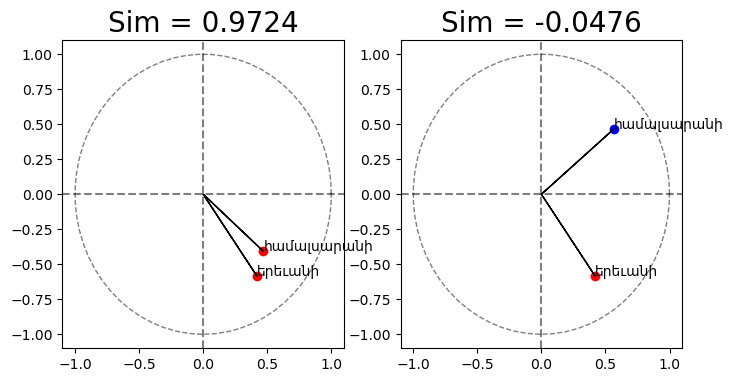

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


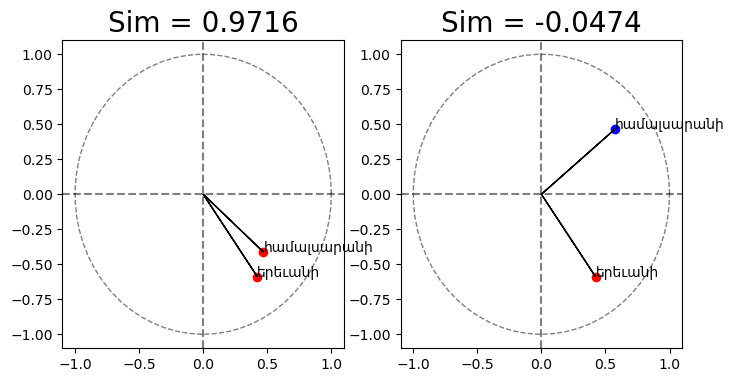

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


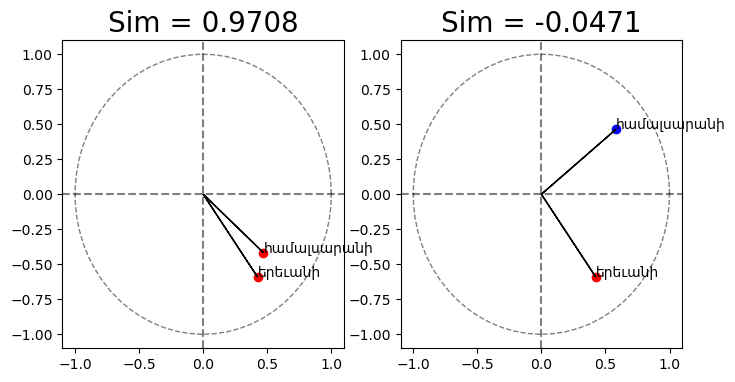

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


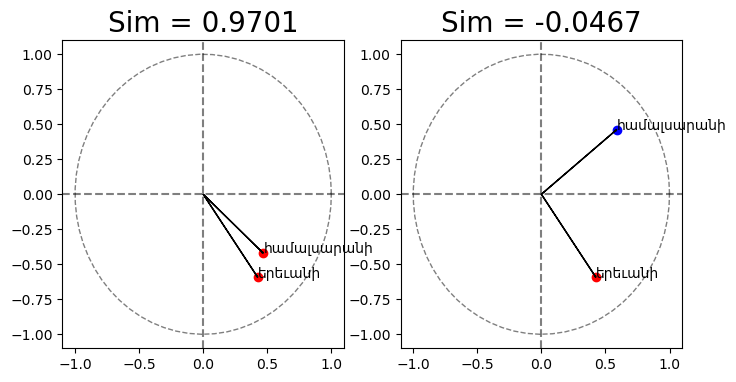

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


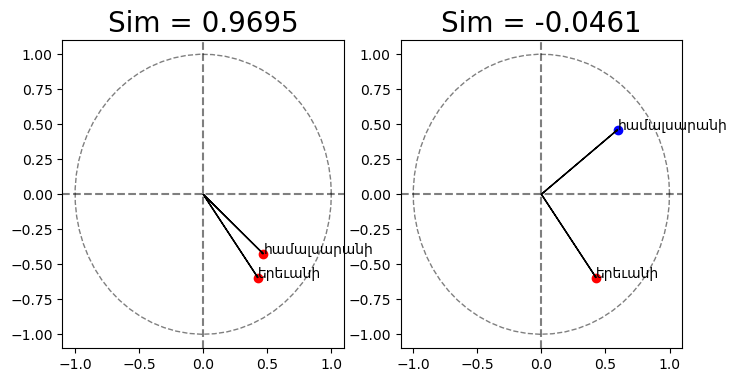

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


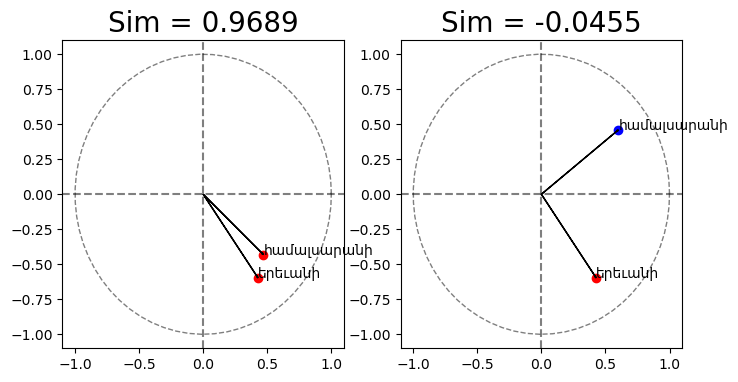

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


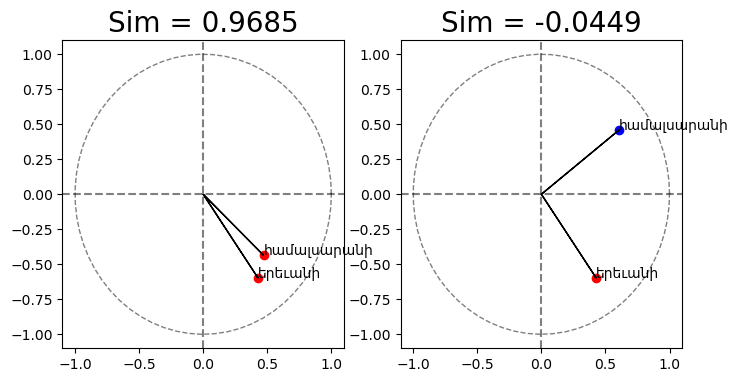

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


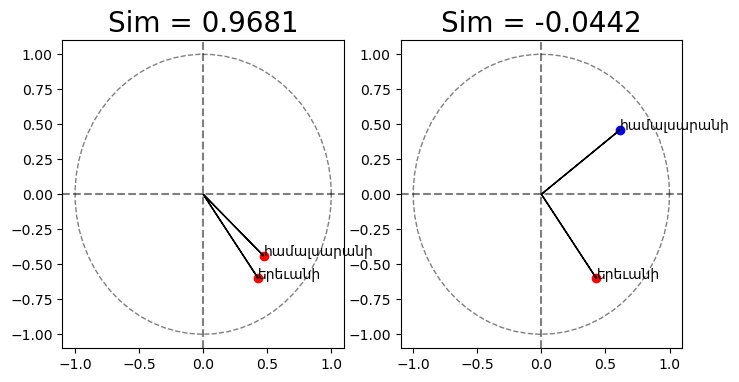

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


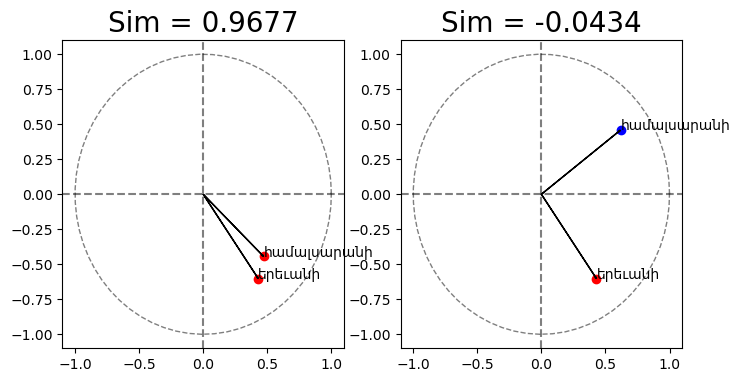

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


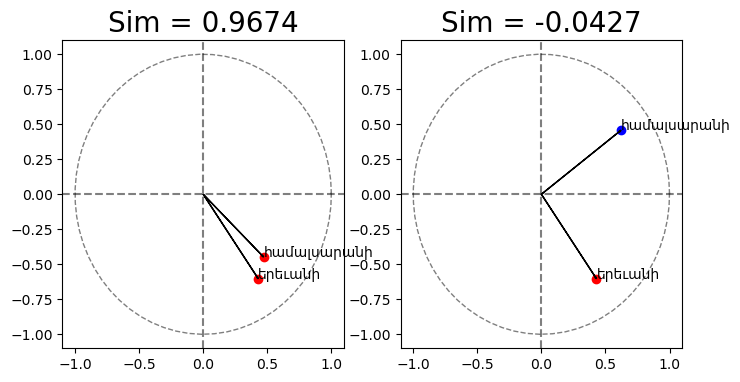

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


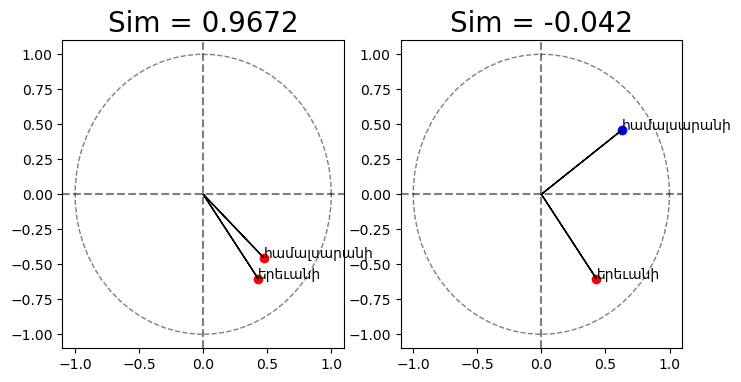

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


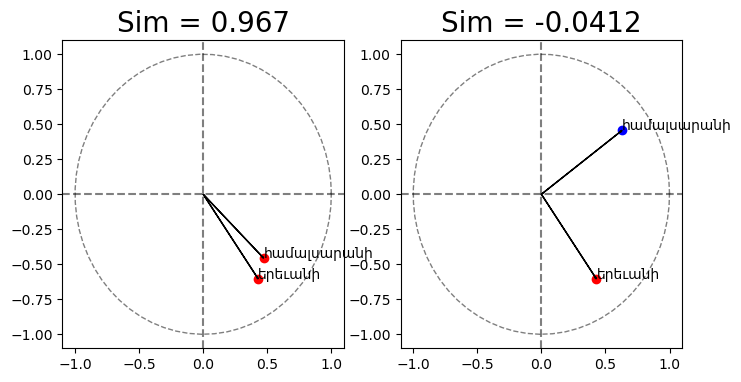

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


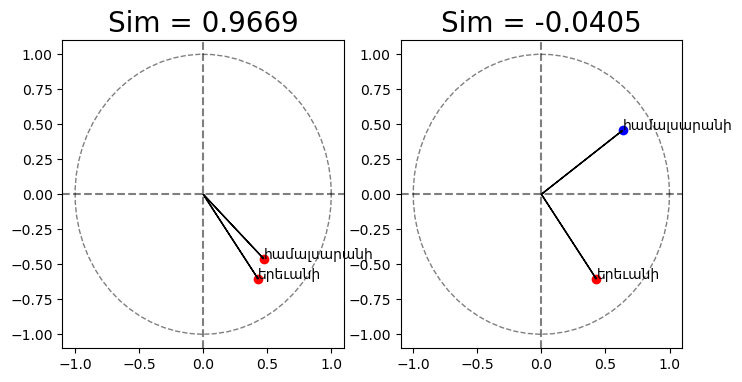

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


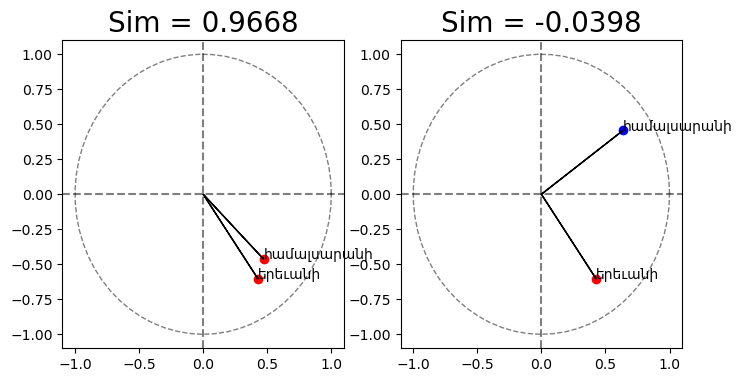

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


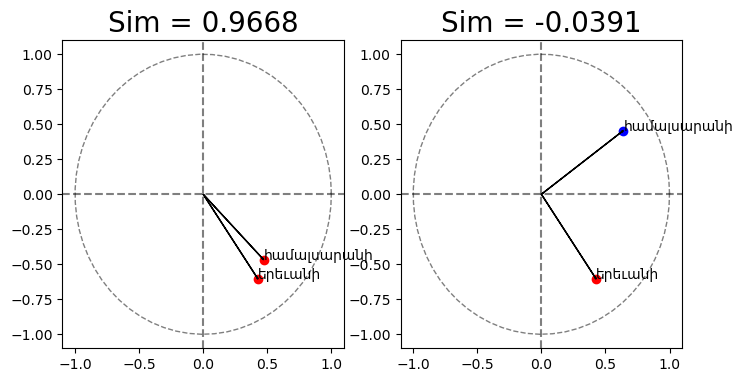

C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
C:\Users\Aren\AppData\Local\Temp\ipykernel_8404\1726916344.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


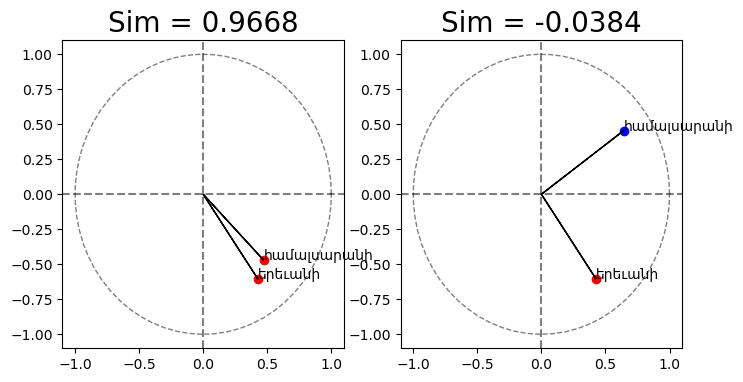

In [59]:
# Create embeddings
EMBEDDING_SIZE = 5
# Target
main_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((main_embeddings**2).sum(axis=1)).reshape(-1,1)
main_embeddings = main_embeddings / row_norms
# Context
context_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data=main_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)
# Gradient Descent progress for 2 words
for _ in range(50):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.05, ['երեւանի', 'համալսարանի'])

In [60]:
# Word 2 word similarity calculation after 50 iter training
L = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            L.append((w1,w2,sim))
sorted([item for item in L if item[0] == 'երեւանի'], key=lambda t: -t[2])[:10]

[('երեւանի', 'հարցին', 0.9932853341558642),
 ('երեւանի', 'իրականացվող', 0.9905616383144614),
 ('երեւանի', 'դատապարտելով', 0.9900294126621374),
 ('երեւանի', 'նախատեսված', 0.9884473009087611),
 ('երեւանի', 'հայհոյանքներ', 0.9866223428635406),
 ('երեւանի', 'ժամանակ', 0.9842962713265572),
 ('երեւանի', 'հայկական', 0.982965822131157),
 ('երեւանի', 'պատասխանելով', 0.9825820112309699),
 ('երեւանի', 'պետական', 0.9823409935101175),
 ('երեւանի', 'տղային', 0.9818107504786626)]

In [ ]:
# Embedding representation with PCA in 2D

In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=2)
transf_embeddings = pca.fit_transform(main_embeddings.values)
words_used = main_embeddings.index

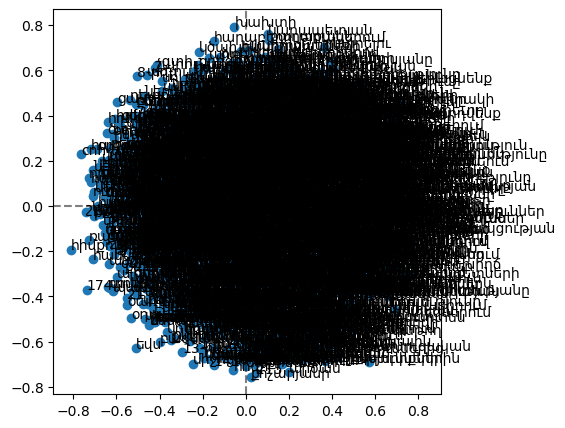

In [63]:
plt.figure(figsize=(5,5))
plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

In [ ]:
# It seems there are a lot of words, so let's just pick the little part of it

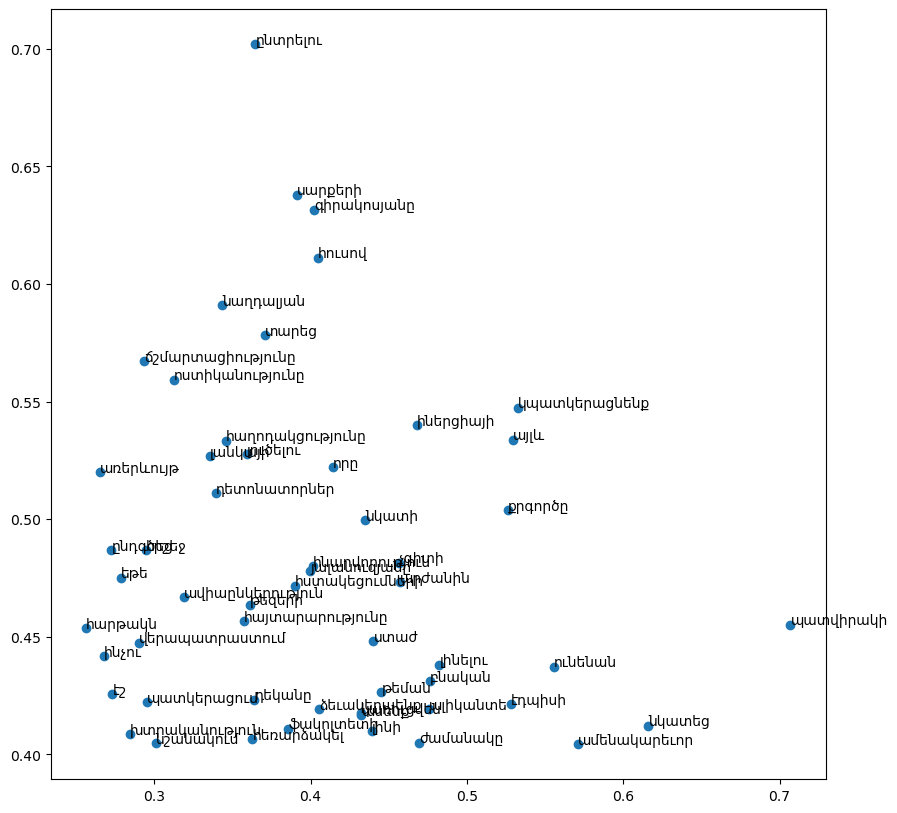

In [64]:
plt.figure(figsize=(10, 10))

chosen_idxs = (transf_embeddings[:,0] > .25) & (transf_embeddings[:,1] > 0.4)
transf_embeddings = transf_embeddings[chosen_idxs]
words_used = words_used[chosen_idxs]

plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))

In [ ]:
# It seems like the training went not that bad, so there are words close to each oder like these:
# Առերևույթ, ոստիկանությունը, ճշմարտացիությունը, քրգործը
# վերապատրաստում, ֆակուլտետի